In [ ]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi
from scipy.stats import binned_statistic_2d

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

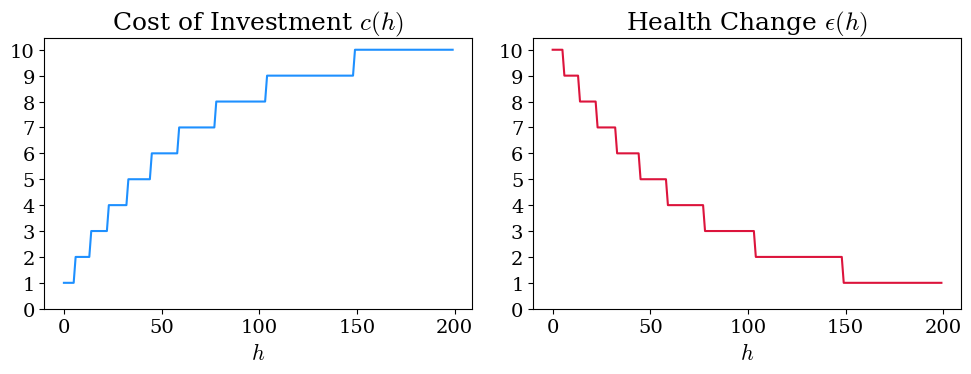

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

x = np.linspace(1,200, 200)
axs[0].plot(compute_health_cost(x), c="dodgerblue")
axs[0].set_title(r"Cost of Investment $c(h)$")
axs[0].set_xlabel(r"$h$")
axs[0].set_yticks(np.arange(11))

axs[1].plot(compute_health_delta(x), c="crimson")
axs[1].set_title(r"Health Change $\epsilon(h)$")
axs[1].set_xlabel(r"$h$")
axs[1].set_yticks(np.arange(11))

fig.tight_layout()
plt.savefig("health_invest_delta.pdf", bbox_inches="tight")
plt.show()

In [51]:
A = []
alpha = []
mean_switches = []

for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)

    A.append(res["params"]["w_delta_scale"])
    alpha.append(res["params"]["alpha"])
    
    wealth = res["wealth"]
    health = res["health"]
    policy = res["policy"]

    w_idx = wealth - 1
    h_idx = health - 1
    choices = policy[w_idx, h_idx]
    diff = np.abs(np.diff(choices, axis=1)).sum(axis=1)
    mean_switches.append(np.mean(diff))

0it [00:00, ?it/s]

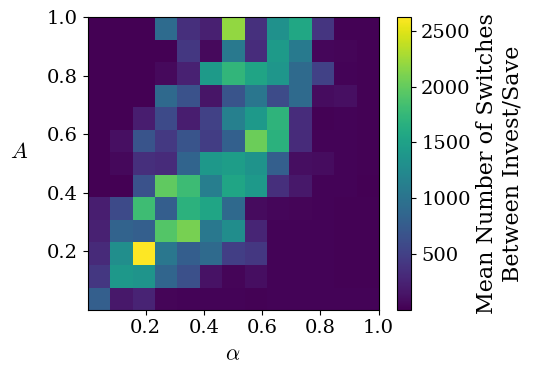

In [75]:
fig, axs = plt.subplots(1, 1, figsize=(5.5,4))

idx1 = 0
idx2 = 4
x = np.array(alpha)
y = np.array(A)
z = np.array(mean_switches)

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
im0 = axs.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
                    aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs, label="Mean Number of Switches\nBetween Invest/Save")
axs.set_xlabel(problem["names"][idx1])
axs.set_ylabel(problem["names"][idx2], rotation=0, labelpad=20)
axs.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])

fig.tight_layout()
plt.savefig("strategy_switches.pdf", bbox_inches="tight")
plt.show()

In [5]:
problem = {
    'num_vars': 7,
    'names': [r"$\alpha$", r"$P_{H_-}$", r"$P_{H_+}$", r"$\gamma$", r"$A$", r"$\omega$", r"$\eta$"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1], [1,4], [0.5,1]]
}

In [6]:
result_suffix = "5"
result_dir = "results_" + result_suffix

### Sen's Welfare Function

In [76]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [6]:
result_dir = "results_" + result_suffix
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open(f"sen_welfare_{result_suffix}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [7]:
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)

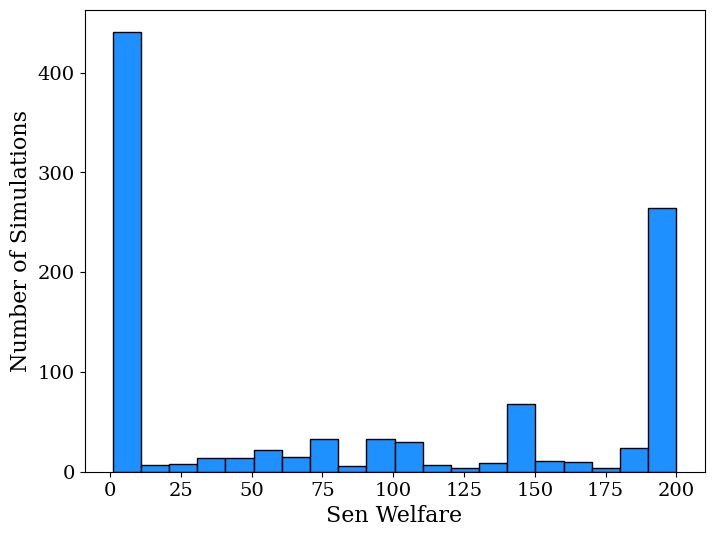

In [8]:
plt.hist(
    [t[1] for t in sen_results],
    bins=20,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Sen Welfare")
plt.ylabel("Number of Simulations")
plt.savefig("sen_welfare.pdf", bbox_inches="tight")
plt.show()

In [9]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["omega"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)


sen_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
print(sen_pawn["mean"])

[0.41692621 0.09956619 0.10389998 0.09580917 0.17478137 0.07758649
 0.08393561]


/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [10]:
morris_result = morris.analyze(problem, X, Y, print_to_console=False)

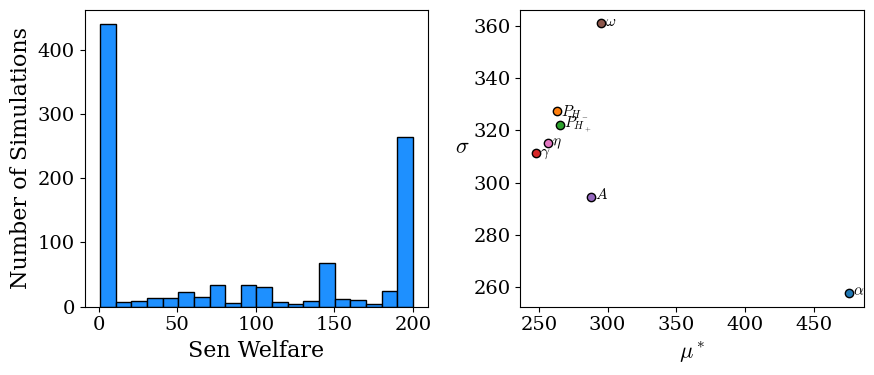

In [13]:
colors = plt.cm.tab10.colors

fig, axs = plt.subplots(1, 2, figsize=(9,4))

# Create the scatter plot with individual colors and labels
for i, (mu, sig, label) in enumerate(zip(morris_result["mu_star"], morris_result["sigma"], problem["names"])):
    plt.scatter(mu, sig, color=colors[i % len(colors)], label=label, edgecolor='k')
    axs[1].text(mu+3, sig-1, label, fontsize=11)

axs[1].set_xlabel(r"$\mu^*$")
axs[1].set_ylabel(r"$\sigma$", rotation=0, labelpad=8)

axs[0].hist(
    [t[1] for t in sen_results],
    bins=20,
    color="dodgerblue",
    edgecolor="k"
)
axs[0].set_xlabel("Sen Welfare")
axs[0].set_ylabel("Number of Simulations")
fig.tight_layout()
plt.savefig("GSA.pdf", bbox_inches="tight")
plt.show()

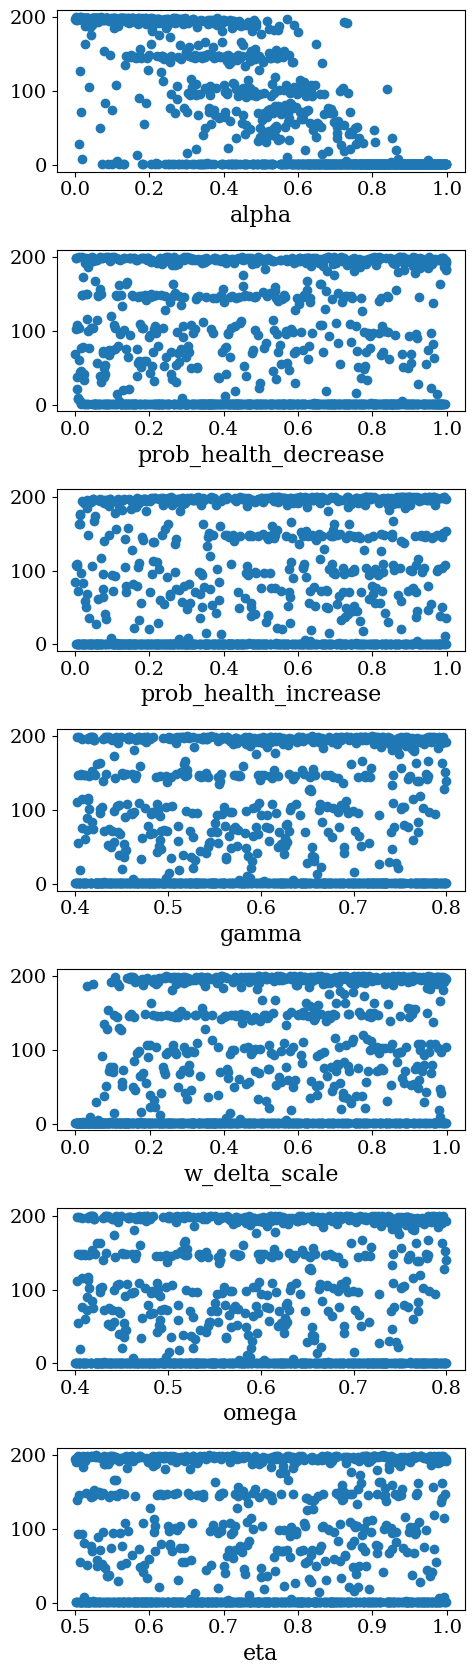

In [10]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,17))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### Minima Locations and Util Improvement

In [9]:
def random_walk(n_steps, start_pos, step_size, interpolate, alpha, exp_factor=1):
    rand_nums = np.random.uniform(0, 1, size=(n_steps,))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps,))

    X = np.zeros((n_steps+1,))
    X[0] = start_pos[0]
    Y = np.zeros((n_steps+1,))
    Y[0] = start_pos[1]
    util = np.zeros((n_steps+1,))
    util[0] = utility(X[0], Y[0], alpha)
    current_potential = interpolate(X[0], Y[0])

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size

        new_x = max(1, min(X[step] + dx, 200))
        new_y = max(1, min(Y[step] + dy, 200))        
        new_potential = interpolate(new_x, new_y, grid=False)

        # check whether to accept or reject moves
        accept = False
        if (new_potential < current_potential) or rand_nums[step] < exp_factor * np.exp(current_potential - new_potential):
            accept = True        
            current_potential = new_potential
            X[step+1] = new_x
            Y[step+1] = new_y
        else:
            X[step+1] = X[step]
            Y[step+1] = Y[step]
        
        util[step+1] = utility(X[step+1], Y[step+1], alpha)

    return util, X, Y

In [12]:
result_dir = "results_" + result_suffix

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open(f"interpolation_functions_{result_suffix}.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [10]:
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

In [6]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima_alternate(func, count_threshold=2))
    )


for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    mins = MINIMA[idx][1]
    for m in mins:
        x, y = m[0]
        if not len(np.where((np.abs(wealth[:,-1] - x) < 5) & (np.abs(health[:,-1] - y) < 5))[0]):
            print(idx, x, y)
            MINIMA[idx] = (MINIMA[idx][0], [elem for elem in MINIMA[idx][1] if elem != m])

with open(f"alternate_minima_{result_suffix}.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [100]:
with open(f"alternate_minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

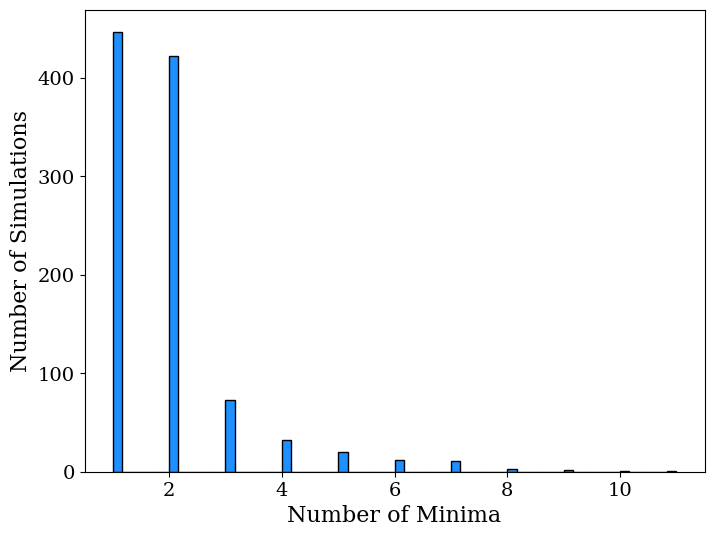

In [101]:
histo = plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=60,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

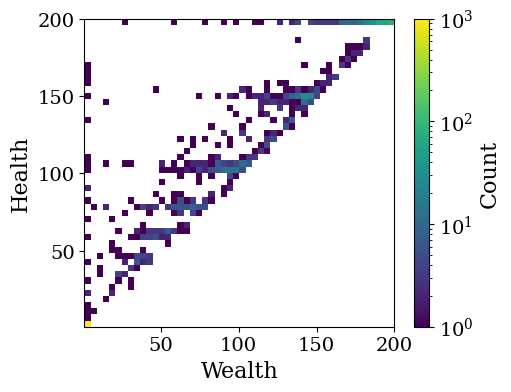

In [13]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.figure(figsize=(5,4))
hist = plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)
cbar = plt.colorbar(hist[3], label="Count")
cbar.set_ticks([1, 10, 100, 1000])

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.savefig("minima_locations.pdf", bbox_inches="tight")
plt.show()

In [69]:
W = []
H = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    W = np.concatenate([W, wealth[:,-1]])
    H = np.concatenate([H, health[:,-1]])

  0%|          | 0/1024 [00:00<?, ?it/s]

In [71]:
combined_F = get_interpolation_function(W,H)

/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_5672/1761504641.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[w][h] = combined_F(w+1, h+1)


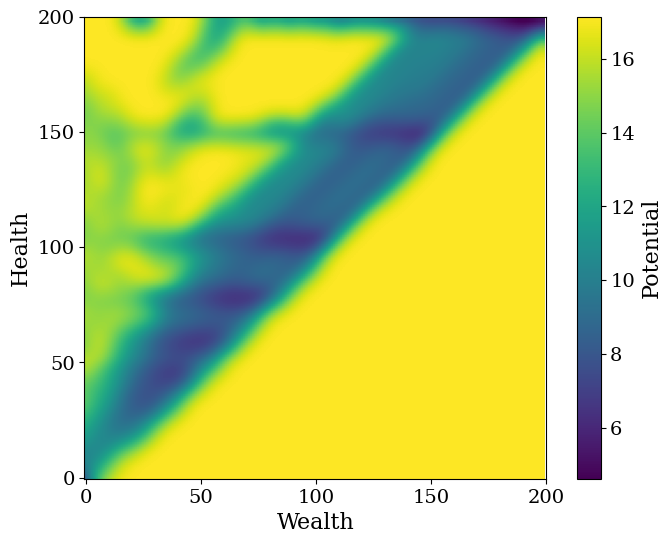

In [83]:
P = np.zeros((200,200))
for w in range(200):
    for h in range(200):
        P[w][h] = combined_F(w+1, h+1)
plt.imshow(P.T, origin="lower")
plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0, 50, 100, 150, 200])
plt.xlabel("Wealth")
plt.ylabel("Health")
plt.colorbar(label="Potential")
plt.savefig("combined_potential.pdf", bbox_inches="tight")
plt.show()

### Radars and Heatmaps

##### Load data, aggregate metrics

In [13]:
with open(f"alternate_minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)
with open(f"alternate_periodic_looping_{result_suffix}.pickle", "rb") as f:
    periodic_looping = pickle.load(f)
with open(f"alternate_flux_{result_suffix}.pickle", "rb") as f:
    flux_result = pickle.load(f)
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)
with open(f"alternate_all_utils_{result_suffix}.pickle", "rb") as f:
    all_utils = pickle.load(f)

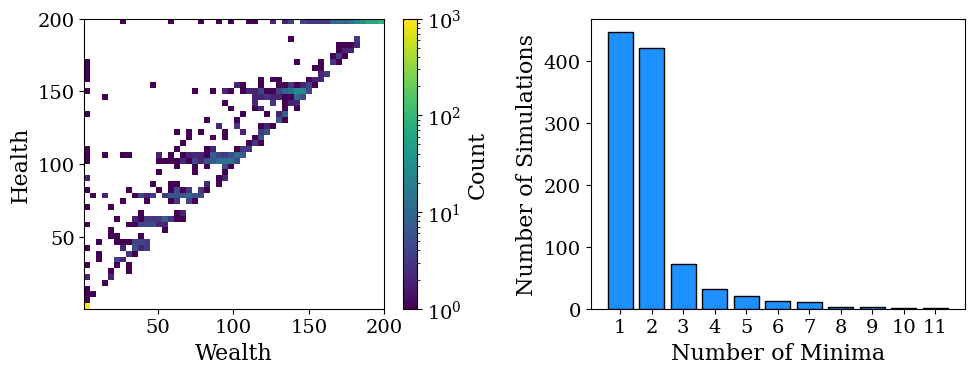

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])
hist = axs[0].hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)
cbar = plt.colorbar(hist[3], label="Count", ax=axs[0])
cbar.set_ticks([1, 10, 100, 1000])

axs[0].set_xlabel("Wealth")
axs[0].set_ylabel("Health")


asdf = dict(Counter([len(x[1]) for x in MINIMA]))
num_min = []
for k in range(1,max(asdf)+1):
    num_min.append(asdf[k])
axs[1].bar(
    np.arange(1,12),
    num_min,
    color="dodgerblue",
    edgecolor="k",
)

axs[1].set_xticks(np.arange(1,12))
axs[1].set_xlabel("Number of Minima")
axs[1].set_ylabel("Number of Simulations")

fig.tight_layout()
plt.savefig("minima.pdf", bbox_inches="tight")
plt.show()

In [62]:
PARAM = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    p = res["params"]
    PARAM.append(
        (p["alpha"],p["P_H_decrease"], p["P_H_increase"], p["gamma"], p["w_delta_scale"], p["gamma"], p["eta"])
    )
PARAM = np.stack(PARAM)

0it [00:00, ?it/s]

In [19]:
def compute_flux(wealth, health, a, b, delta=4):
    inn, out = 0, 0
    visits = np.zeros(wealth.shape[0])
    for t in range(wealth.shape[1]):        
        # IN
        if t == 0:
            reached = np.where( (np.abs(wealth[:,t] - a) <= delta) & (np.abs(health[:,t] - b) <= delta) )[0]
        else:
            reached = np.where( ((np.abs(wealth[:,t] - a) <= delta) & (np.abs(health[:,t] - b) <= delta)) & 
                                 ((np.abs(wealth[:,t-1] - a) > delta) | (np.abs(health[:,t-1] - b) > delta)) )[0]
        inn += len(reached)
        visits[reached] +=1
        # OUT
        if t > 0:
            left = np.where( ((np.abs(wealth[:,t] - a) > delta) | (np.abs(health[:,t] - b) > delta)) & 
                             ((np.abs(wealth[:,t-1] - a) <= delta) & (np.abs(health[:,t-1] - b) <= delta)) )[0]
            out += len(left)

    return (inn,out), visits


def is_periodic(signal):
    """
    Determine if a signal is periodic using autocorrelation.

    Parameters:
    signal (array-like): The input signal.
    threshold (float): The threshold for detecting periodicity. Default is 0.8.

    Returns:
    bool: True if the signal is periodic, False otherwise.
    """
    autocorr = correlate(signal, signal, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    max_autocorr = np.max(autocorr)
    second_max_autocorr = np.sort(autocorr)[-2]
    return (second_max_autocorr / max_autocorr)


def radar_plot(X1, X2, labels):
    colors = ['dodgerblue', 'crimson']
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    for i,arr in enumerate([X1, X2]):
        means = np.mean(arr, axis=0)
        stds = np.std(arr, axis=0)
        
        num_vars = len(means)
        
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Close the polygon
        
        values = means.tolist()
        values += values[:1]
        
        std_upper = (means + stds).tolist()
        std_upper += std_upper[:1]
        std_lower = (means - stds).tolist()
        std_lower += std_lower[:1]
        
        ax.plot(angles, values, color=colors[i], linewidth=1, label=labels[i])
        ax.fill_between(angles, std_lower, std_upper, color=colors[i], alpha=0.1)

    labels = [r"$\alpha$", r"$P_{H_-}$", r"$P_{H_+}$", r"$\gamma$", r"$A$", r"$\omega$", r"$\eta$"]
    ax.legend()
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    plt.show()

In [129]:
flux_result = []
for idx,f in tqdm(enumerate(os.listdir(result_dir))):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    r = {}
    for m in MINIMA[idx][1]:
        a,b = m[0]
        in_out_counts, visits = compute_flux(wealth, health, a, b)
        r[(a,b)] = (in_out_counts, visits)
    flux_result.append((idx, r))

with open(f"alternate_flux_{result_suffix}.pickle", "wb") as f:
    pickle.dump(flux_result, f)

0it [00:00, ?it/s]

In [130]:
periodic_looping = {}

for idx, f in tqdm(enumerate(os.listdir(result_dir))):

    with open(os.path.join(result_dir, f), "rb") as file:
        res = pickle.load(file)
    wealth = res["wealth"]
    health = res["health"]

    mins = MINIMA[idx][1]
    if len(mins) == 1:
        periodic_looping[idx] = periodic_count = np.zeros((10000,))
        continue
    min_dict = {
        (mins[i][0][0], mins[i][0][1]): i for i in range(len(mins))
    }
    
    minima_array = np.array(list(min_dict.keys()))
    
    # Stack wealth and health into shape (10000, 5000, 2)
    agent_positions = np.stack((wealth, health), axis=-1)

    # Compute distances to each minimum
    distances = np.linalg.norm(
        agent_positions[:, :, None, :] - minima_array[None, None, :, :], axis=-1
    )

    # Get the index of the closest minimum
    closest_minima = np.argmin(distances, axis=-1)

    periodic_count = np.zeros((10000,))
    for j,row in enumerate(closest_minima):
        change_indices = np.where(np.diff(row) != 0)[0] + 1
        collapsed = row[np.insert(change_indices, 0, 0)]
        if len(collapsed) < 5:
            continue
        periodic_count[j] = is_periodic(collapsed[2:])

    periodic_looping[idx] = periodic_count

with open(f"alternate_periodic_looping_{result_suffix}.pickle", "wb") as f:
    pickle.dump(periodic_looping, f)

0it [00:00, ?it/s]

In [140]:
loopy = set()
threshold = 0.85
for key in periodic_looping:
    if len(np.where(periodic_looping[key] > threshold)[0]) > 4000:
        loopy.add(key)

In [9]:
# for idx in loopy:
#     asdf = np.zeros((200,200))
#     for w in range(200):
#         for h in range(200):
#             asdf[w][h] = interpolation_functions[idx][1](w+1,h+1)
#     plt.imshow(asdf.T, origin="lower")
#     plt.show()

##### Loops

In [141]:
loop = []
noloop = []
for idx,_ in enumerate(os.listdir(result_dir)):
    if idx in loopy:
        loop.append(
            PARAM[idx]
        )
    else:
        noloop.append(
            PARAM[idx]
        )
loop = np.stack(loop)
noloop = np.stack(noloop)

##### Number of Revisits

In [137]:
high_revisit = set()
for item in flux_result:
    idx = item[0]
    mins = item[1]
    for k in mins:
        revisits = mins[k][1][np.where(mins[k][1] > 0)[0]]
        mean_revisit = np.mean(revisits)
        if mean_revisit > 100:
            high_revisit.add(idx)

high_rev = []
low_rev = []
for idx,f in enumerate(os.listdir(result_dir)):
    if idx in high_revisit:
        high_rev.append(
            PARAM[idx]
        )
    else:
        low_rev.append(
            PARAM[idx]
        )
high_rev = np.stack(high_rev)
low_rev = np.stack(low_rev)

##### Number of Minima

In [138]:
single_min = set()
for item in flux_result:
    idx = item[0]
    mins = item[1]
    if len(mins) == 1:
        single_min.add(idx)

single_min_arr = []
multi_min_arr = []
for idx,f in enumerate(os.listdir(result_dir)):
    if idx in single_min:
        single_min_arr.append(
            PARAM[idx]
        )
    else:
        multi_min_arr.append(
            PARAM[idx]
        )

single_min_arr = np.stack(single_min_arr)
multi_min_arr = np.stack(multi_min_arr)

##### Mobility

In [142]:
with open(f"alternate_all_utils_{result_suffix}.pickle", "rb") as f:
    all_utils = pickle.load(f)

high_mob = set()
for idx,item in enumerate(all_utils):
    if item[1] > 5:
        high_mob.add(idx)
print(len(high_mob))

high_mobility = []
low_mobility = []
for idx,f in enumerate(os.listdir(result_dir)):
    if idx in high_mob:
        high_mobility.append(
            PARAM[idx]
        )
    else:
        low_mobility.append(
            PARAM[idx]
        )
high_mobility = np.stack(high_mobility)
low_mobility = np.stack(low_mobility)

252


##### Sen Welfare

In [143]:
high_sen = set()
for idx,item in enumerate(sen_results):
    if item[1] > 175:
        high_sen.add(idx)

high_sen_arr = []
low_sen_arr = []
for idx,f in enumerate(os.listdir(result_dir)):
    if idx in high_sen:
        high_sen_arr.append(
            PARAM[idx]
        )
    else:
        low_sen_arr.append(
            PARAM[idx]
        )
high_sen_arr = np.stack(high_sen_arr)
low_sen_arr = np.stack(low_sen_arr)

##### "Stability"

In [144]:
stability_counts = {}
for item in flux_result:
    idx = item[0]
    mins = item[1]
    sc = {"stable":0, "unstable":0}
    for k in mins:
        inn, out = mins[k][0]
        if inn / (out+1e-5) > 3:
            sc["stable"] += 1
        else:
            sc["unstable"] += 1
    stability_counts[idx] = sc

stable = []
unstable = []
for idx,f in enumerate(os.listdir(result_dir)):
    if stability_counts[idx]["stable"] > 1:
        stable.append(
            PARAM[idx]
        )
    else:
        unstable.append(
            PARAM[idx]
        )
stable = np.stack(stable)
unstable = np.stack(unstable)

##### Radar Plots

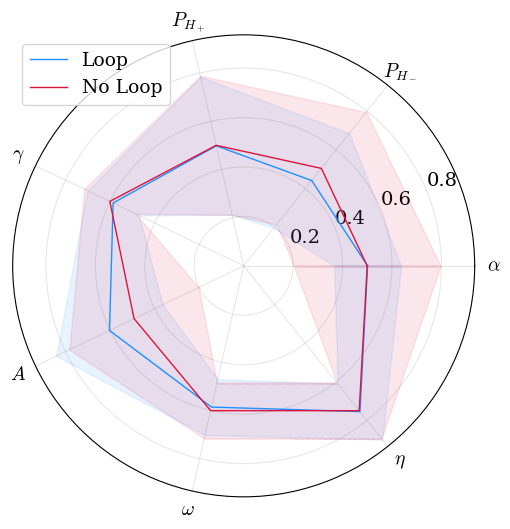

In [146]:
radar_plot(loop, noloop, labels=["Loop", "No Loop"])

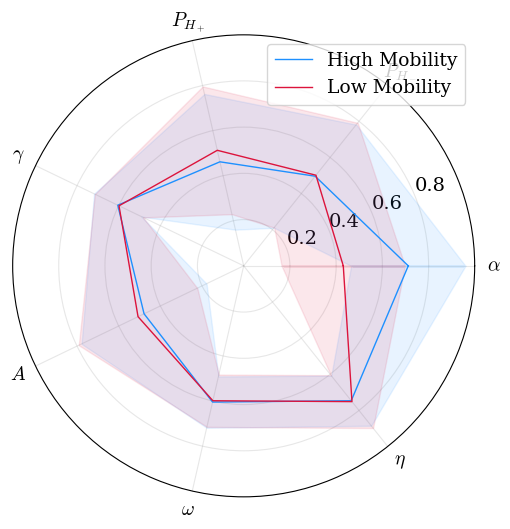

In [147]:
radar_plot(high_mobility, low_mobility, labels=["High Mobility", "Low Mobility"])

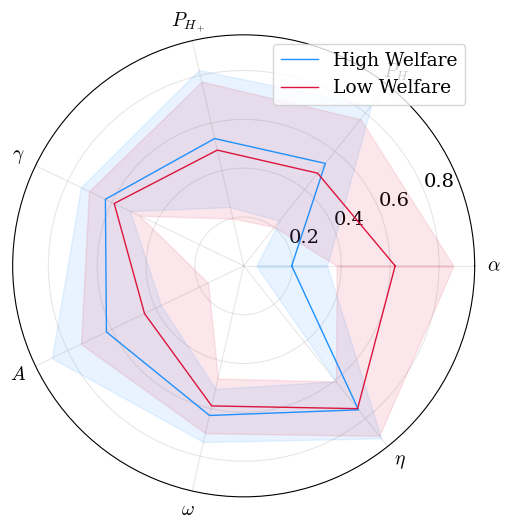

In [148]:
radar_plot(high_sen_arr, low_sen_arr, labels=["High Welfare", "Low Welfare"])

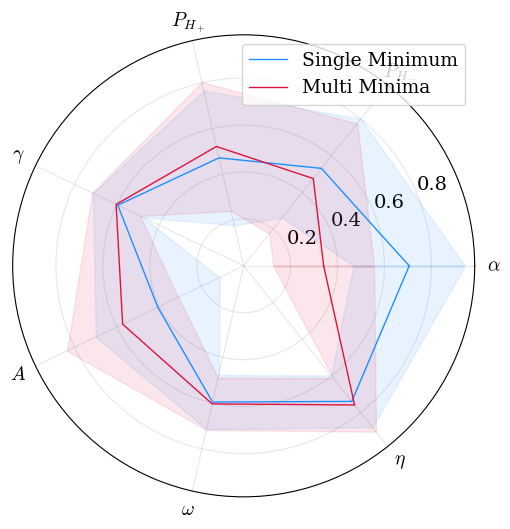

In [149]:
radar_plot(single_min_arr, multi_min_arr, labels=["Single Minimum", "Multi Minima"])

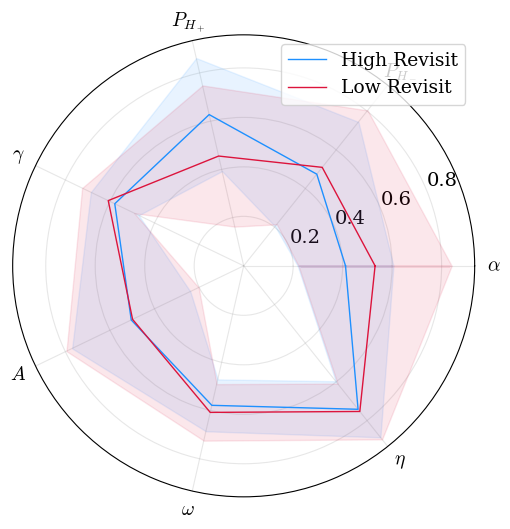

In [150]:
radar_plot(high_rev, low_rev, labels=["High Revisit", "Low Revisit"])

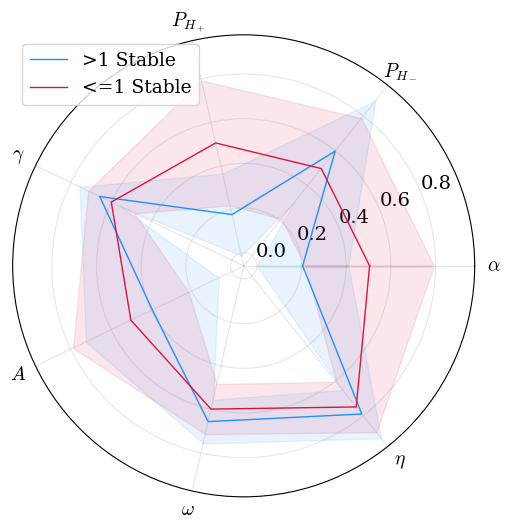

In [151]:
radar_plot(stable, unstable, labels=[">1 Stable", "<=1 Stable"])

##### Bifurcation diagrams

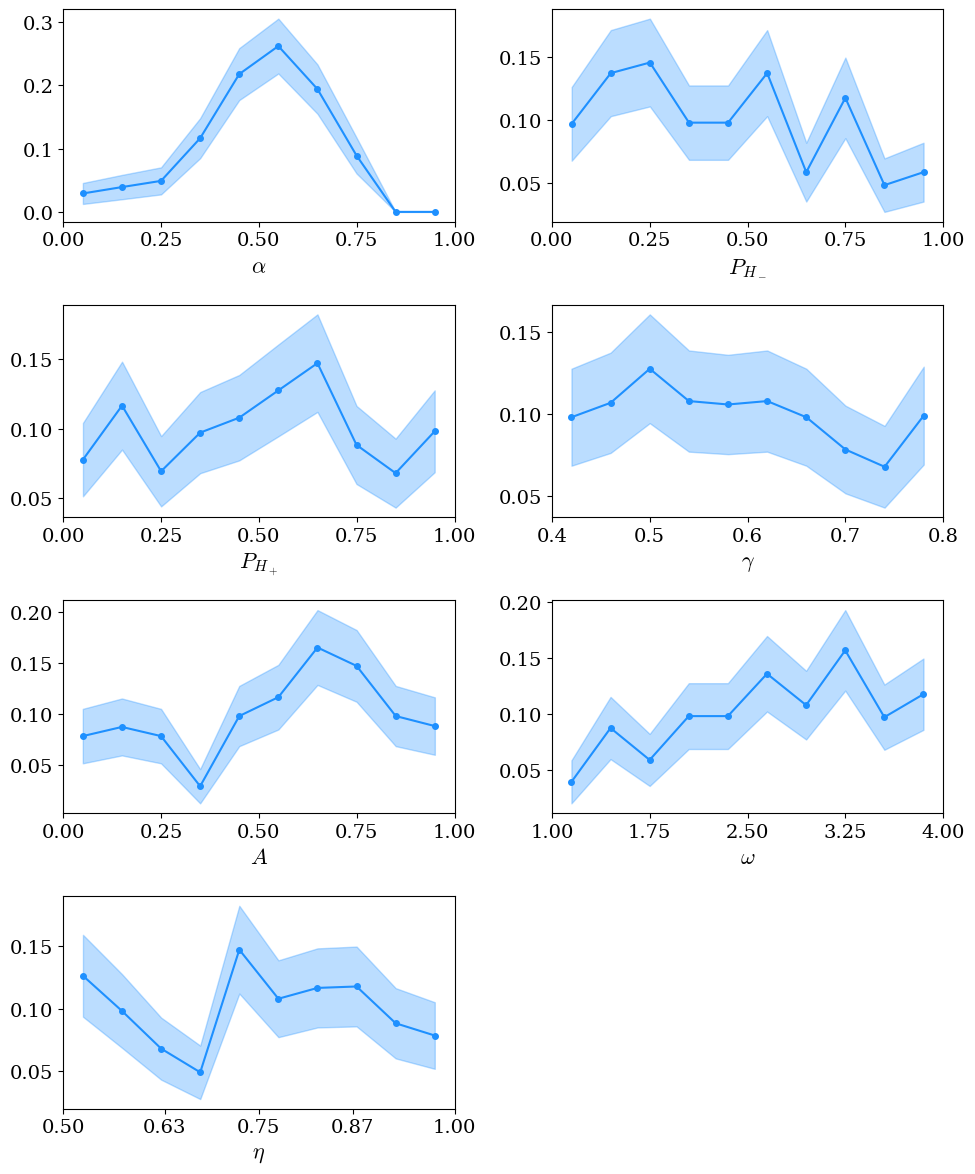

In [55]:
num_features = X.shape[1]
n_rows = 4
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 12))
axs = axs.flatten()

cycle_bool = [int(periodic_looping[idx].max() > 0.90) and int(periodic_looping[idx].mean() > 0.1) for idx in range(1024)]

num_bins = 11
for i in range(num_features):
    min_val, max_val = X[:, i].min(), X[:, i].max()
    x = np.linspace(min_val, max_val, num_bins)
    num_cycles = np.zeros((num_bins - 1,))
    counts = np.zeros((num_bins - 1,))
    for idx, val in enumerate(X[:, i]):
        for j in range(len(x) - 1):
            if x[j] <= val < x[j + 1]:
                num_cycles[j] += cycle_bool[idx]
                counts[j] += 1
    cycle_prob = num_cycles / counts
    cycle_se = np.sqrt((cycle_prob)*(1-cycle_prob)/counts)

    axs[i].plot(np.diff(x) / 2 + x[:-1], cycle_prob, marker='o', color="dodgerblue", markersize=4)
    axs[i].fill_between(np.diff(x) / 2 + x[:-1], y1=cycle_prob-cycle_se, y2=cycle_prob+cycle_se, alpha=0.3, color="dodgerblue")
    axs[i].set_xlabel(problem["names"][i])
    axs[i].set_xticks(np.linspace(min_val, max_val, 5).round(2))

for j in range(num_features, len(axs)):
    axs[j].axis('off')

fig.tight_layout()
plt.savefig("bifurcation_plots.pdf", bbox_inches="tight")
plt.show()

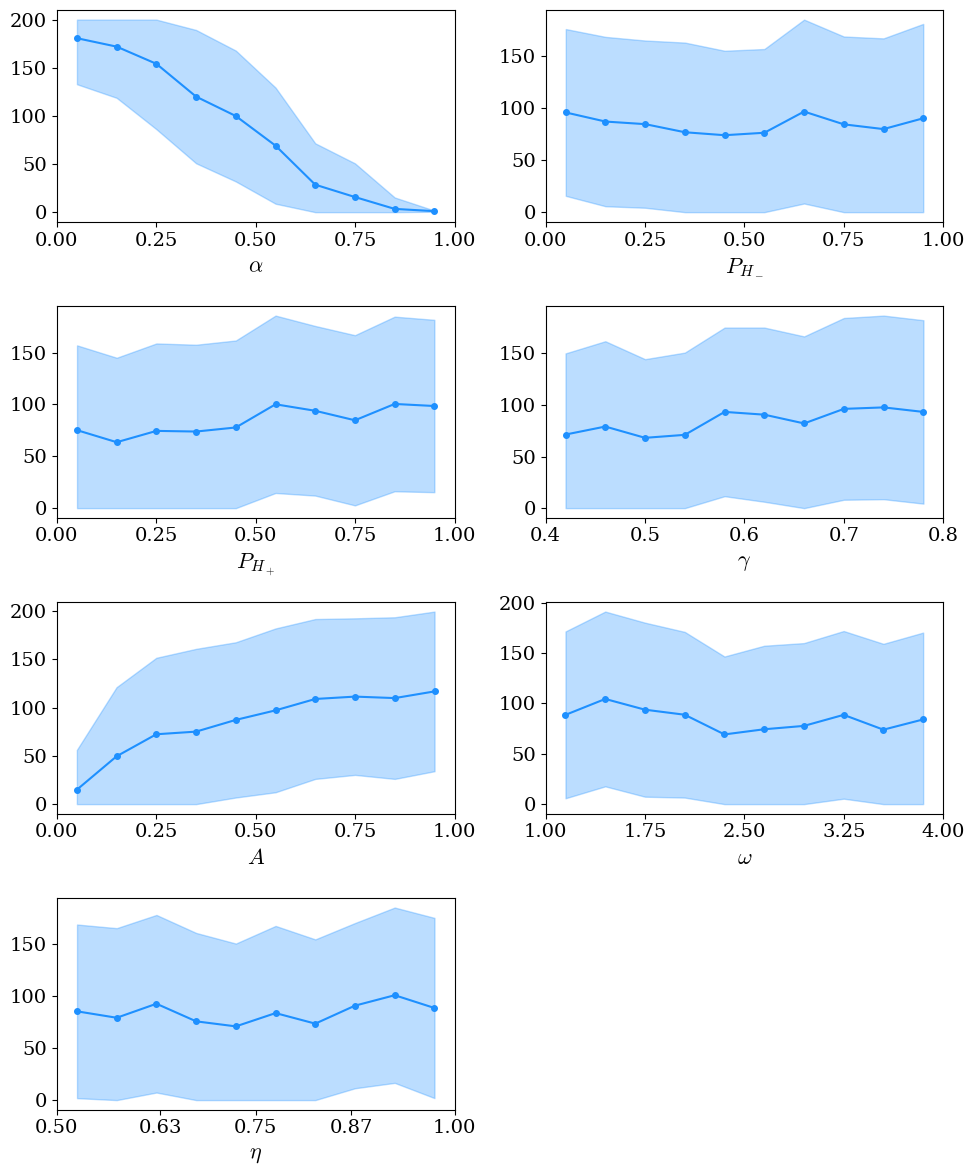

In [59]:
num_features = X.shape[1]
n_rows = 4
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 12))
axs = axs.flatten()

num_bins = 11
for i in range(num_features):
    min_val, max_val = X[:, i].min(), X[:, i].max()
    x = np.linspace(min_val, max_val, num_bins)
    
    welfare = np.zeros((num_bins - 1,))
    counts = np.zeros((num_bins - 1,))
    welfares = {j:[] for j in range(len(x)-1)}

    for idx, val in enumerate(X[:, i]):
        for j in range(len(x) - 1):
            if x[j] <= val < x[j + 1]:
                welfare[j] += sen_results[idx][1]
                welfares[j].append(sen_results[idx][1])
                counts[j] += 1
    
    avg_welfare = welfare / counts
    std_welfare = [np.std(welfares[k]) for k in sorted(list(welfares.keys()))]

    axs[i].plot(np.diff(x) / 2 + x[:-1], avg_welfare, marker='o', color="dodgerblue", markersize=4)
    axs[i].fill_between(np.diff(x) / 2 + x[:-1], y1=np.maximum(0,np.array(avg_welfare-std_welfare)), y2=np.minimum(200,avg_welfare+std_welfare), alpha=0.3, color="dodgerblue")
    axs[i].set_xlabel(problem["names"][i])
    axs[i].set_xticks(np.linspace(min_val, max_val, 5).round(2))

for j in range(num_features, len(axs)):
    axs[j].axis('off')

fig.tight_layout()
plt.savefig("welfare_bifurcation.pdf", bbox_inches="tight")
plt.show()

##### Heatmaps

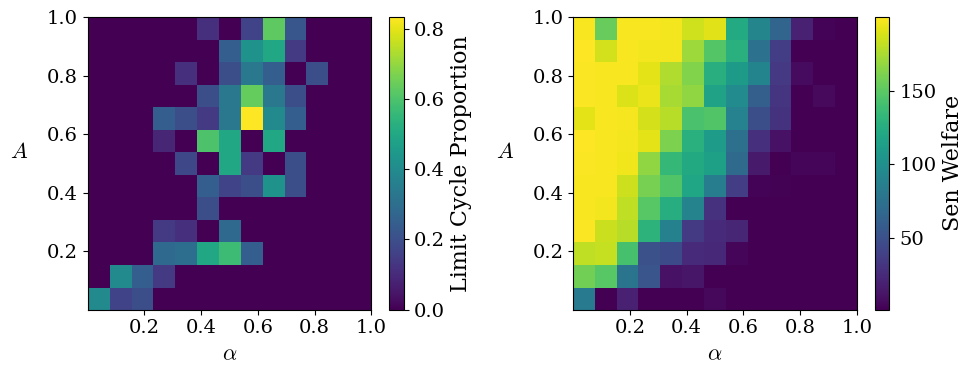

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

idx1 = 0
idx2 = 4
x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [int(periodic_looping[idx].max() > 0.90) and int(periodic_looping[idx].mean() > 0.1) for idx in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
im0 = axs[0].imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
                    aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0], label="Limit Cycle Proportion")
axs[0].set_xlabel(problem["names"][idx1])
axs[0].set_ylabel(problem["names"][idx2], rotation=0, labelpad=20)
axs[0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[0].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
idx1 = 0
idx2 = 4
x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [sen_results[i][1] for i in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
im1 = axs[1].imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
                    aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1], label="Sen Welfare", ticks=[50, 100, 150, 200])
axs[1].set_xlabel(problem["names"][idx1])
axs[1].set_ylabel(problem["names"][idx2], rotation=0, labelpad=20)
axs[1].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[1].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])

fig.tight_layout()
plt.savefig("parameter_heatmaps.pdf", bbox_inches="tight")
plt.show()

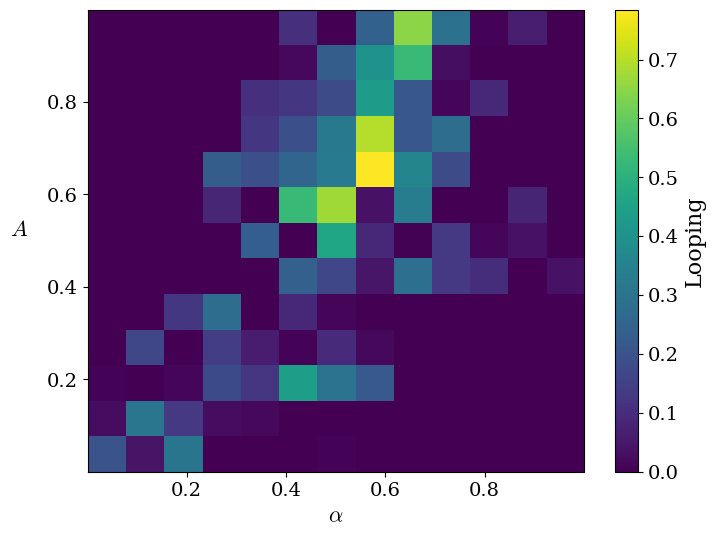

In [130]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [periodic_looping[idx].mean() for idx in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.colorbar(label="Looping")
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.show()

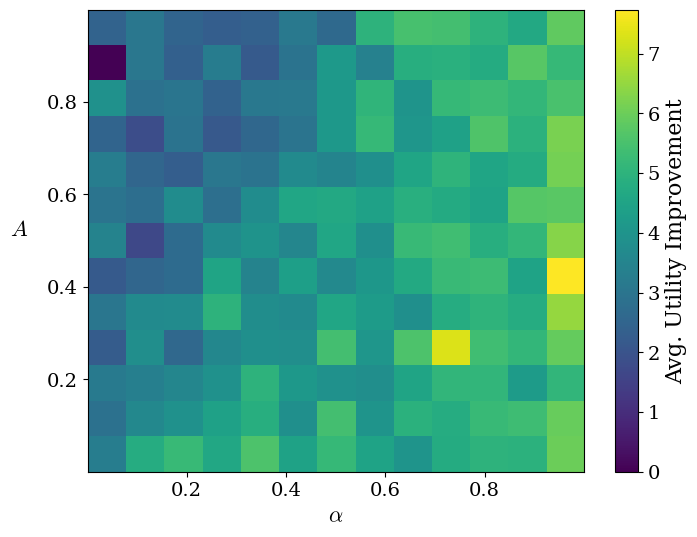

In [132]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [all_utils[i][1] for i in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.colorbar(label="Avg. Utility Improvement")
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.show()

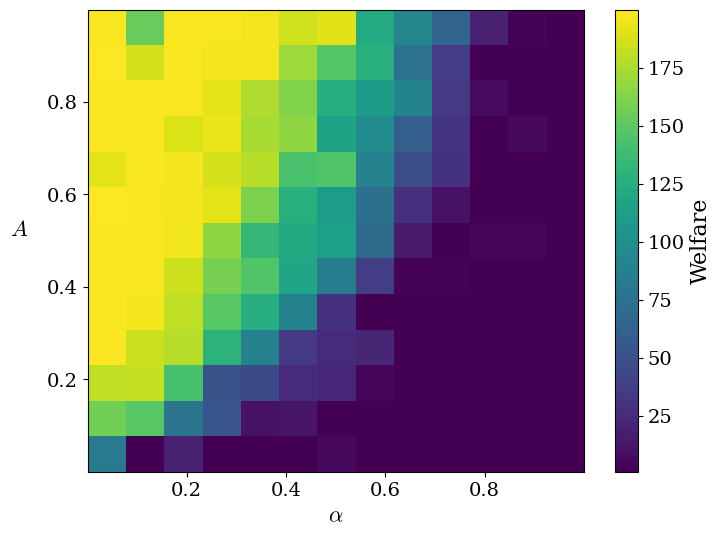

In [133]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [sen_results[i][1] for i in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.colorbar(label="Welfare")
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.show()

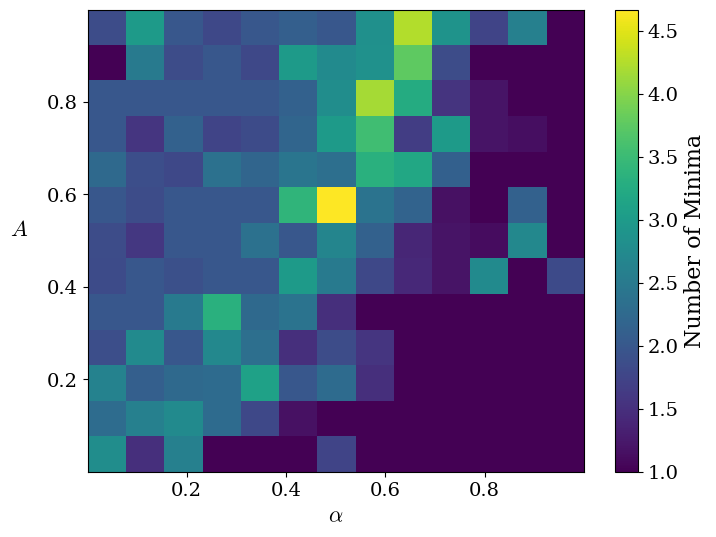

In [134]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = [len(MINIMA[i][1]) for i in range(1024)]

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.colorbar(label="Number of Minima")
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.show()

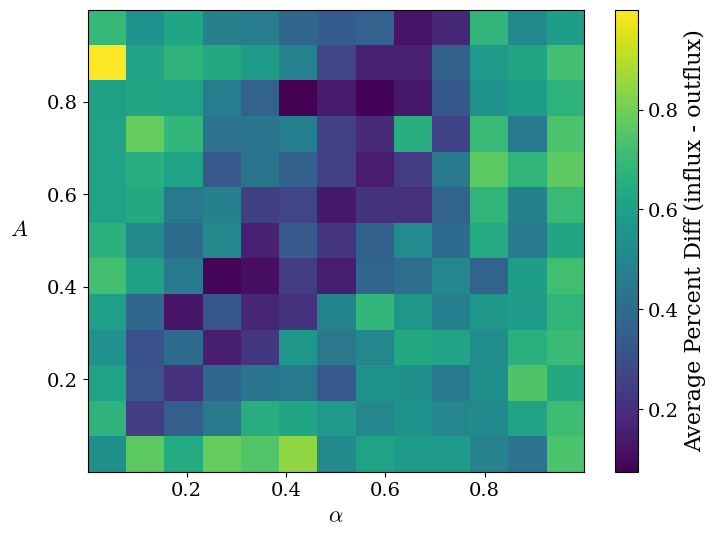

In [135]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = []
for item in flux_result:
    idx = item[0]
    mins = item[1]
    sc = []
    for k in mins:
        inn, out = mins[k][0]
        sc.append((inn - out) / inn)
    z.append(np.mean(sc))

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.colorbar(label="Average Percent Diff (influx - outflux)")
plt.show()

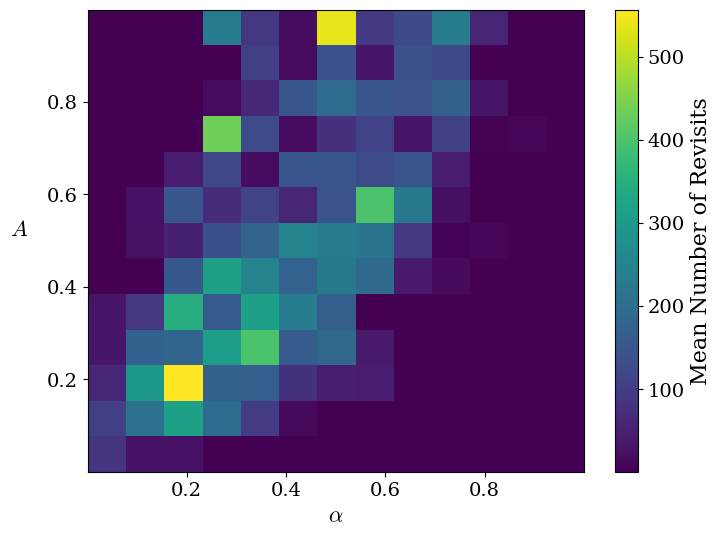

In [136]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = []

for item in flux_result:
    idx = item[0]
    mins = item[1]
    r = []
    for k in mins:
        revisits = mins[k][1][np.where(mins[k][1] > 0)[0]]
        r.append(np.mean(revisits))
    z.append(np.mean(r))

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.colorbar(label="Mean Number of Revisits")
plt.show()

  0%|          | 0/1024 [00:00<?, ?it/s]

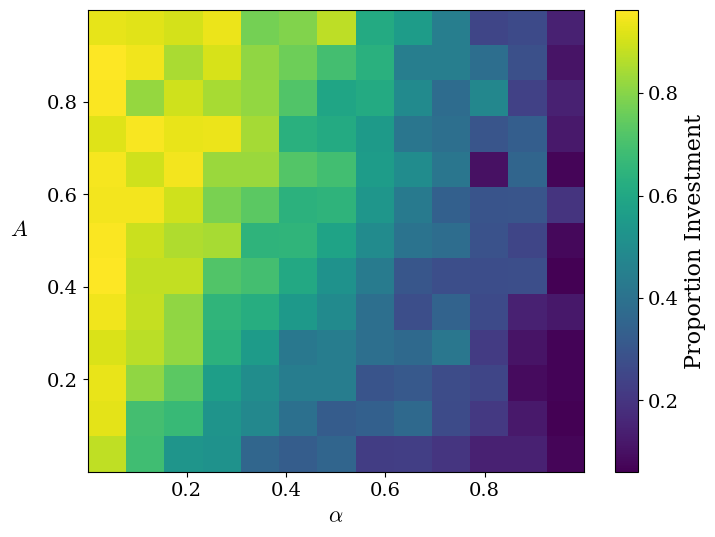

In [41]:
idx1 = 0
idx2 = 4

x = PARAM[:,idx1]
y = PARAM[:,idx2]
z = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    z.append(res["policy"].flatten().mean())

statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
    x, y, z, statistic='mean', bins=13, range=[[x.min(), x.max()], [y.min(), y.max()]]
)
plt.figure(figsize=(8, 6))
plt.imshow(statistic.T, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], 
           aspect='auto', cmap='viridis')
plt.xlabel(problem["names"][idx1])
plt.ylabel(problem["names"][idx2], rotation=0, labelpad=20)
plt.colorbar(label="Proportion Investment")
plt.show()

### Minima Zoo

120


/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_38489/2413798572.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)


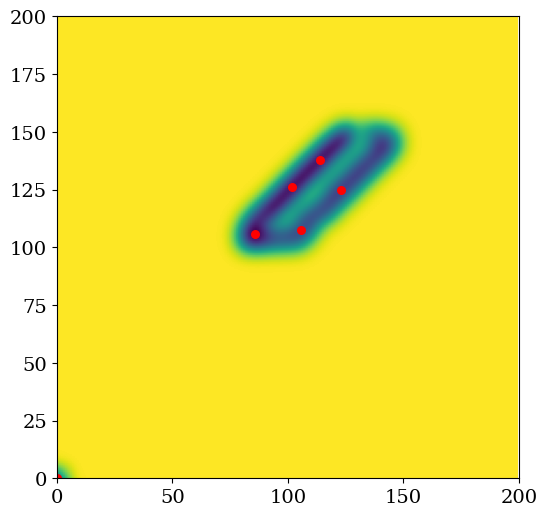

253


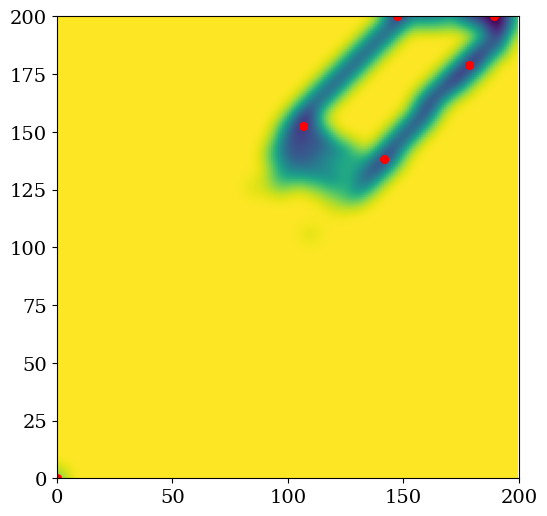

264


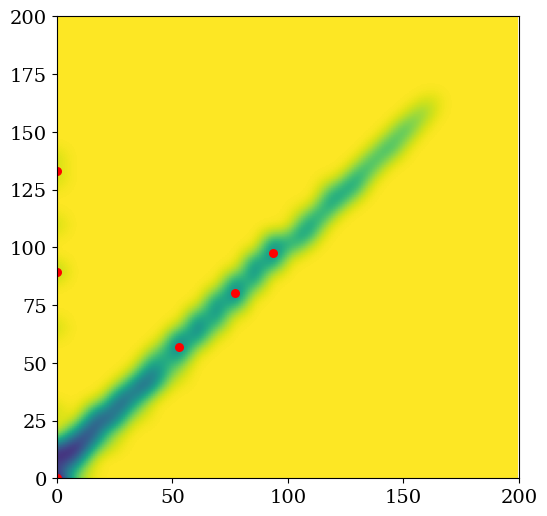

549


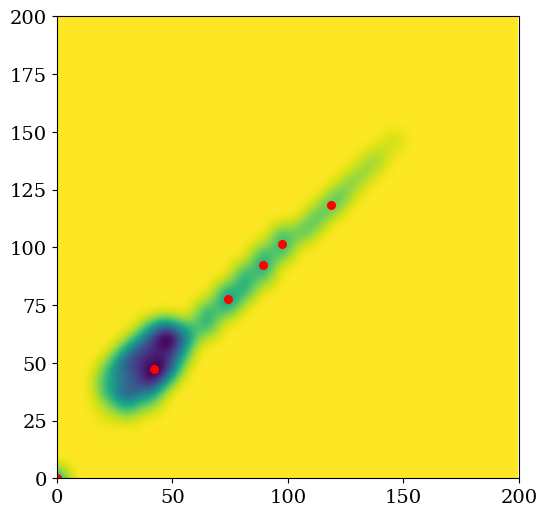

770


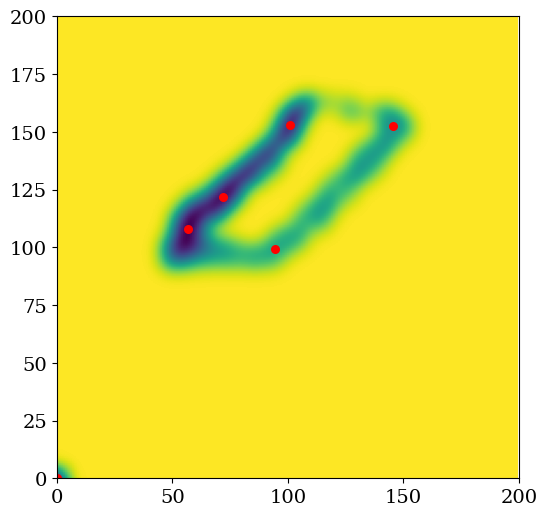

849


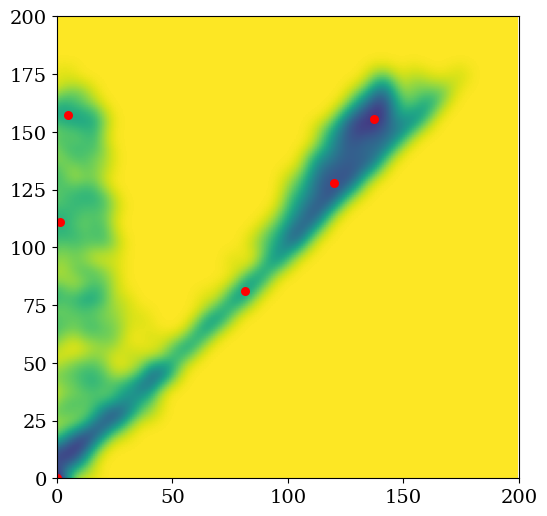

896


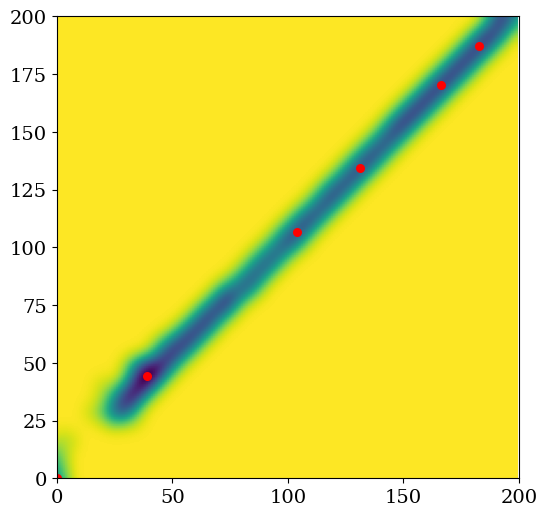

970


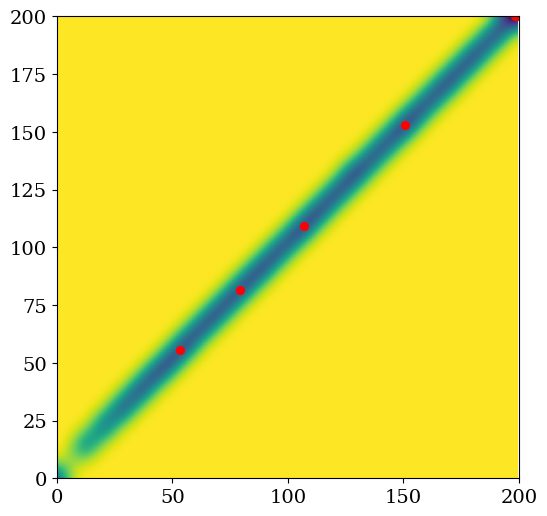

In [275]:
minima_locations = []
for i,m in enumerate(MINIMA):
    if len(m[1]) == 6:
        print(i)
        asdf = np.zeros((200,200))
        func = interpolation_functions[i][1]
        points = m[1]
        zero_zero = False
        # for p in points:
        #     if p[0][0] == 0 and p[0][1] == 0:
        #         zero_zero = True
        # if not zero_zero:
        #     print(points)
        for w in range(200):
            for h in range(200):
                asdf[w][h] = func(w,h)
        plt.imshow(asdf.T, origin="lower")
        plt.scatter(
            [p[0][0] for p in points],
            [p[0][1] for p in points], 
            color="red", s=30
        )
        plt.xlim(0,200)
        plt.ylim(0,200)
        plt.show()

/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_52099/3072873461.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_52099/3072873461.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_52099/3072873461.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/

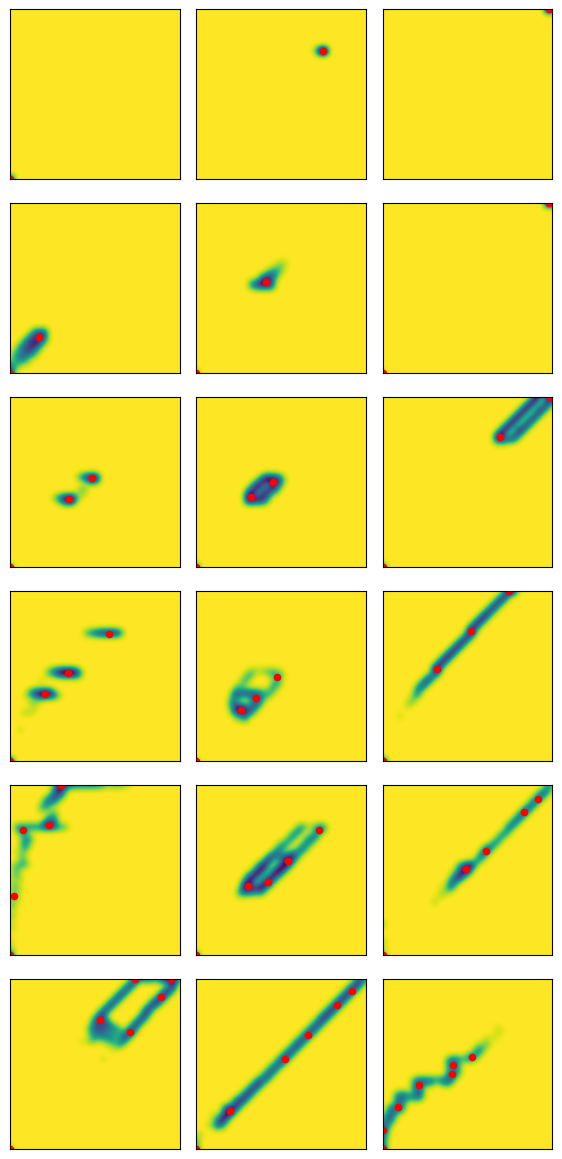

In [14]:
fig, axs = plt.subplots(6, 3, figsize=(7,15))

# 1 minimum
indices = [3, 106, 431]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[0][i].imshow(asdf.T, origin="lower")
    axs[0][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[0][i].set_xlim(0,200)
    axs[0][i].set_ylim(0,200)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])

# 2 minima
indices = [130, 2, 197]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[1][i].imshow(asdf.T, origin="lower")
    axs[1][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[1][i].set_xlim(0,200)
    axs[1][i].set_ylim(0,200)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])

# 3 minima
indices = [512, 387, 757]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[2][i].imshow(asdf.T, origin="lower")
    axs[2][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[2][i].set_xlim(0,200)
    axs[2][i].set_ylim(0,200)
    axs[2][i].set_xticks([])
    axs[2][i].set_yticks([])

# 4 minima
indices = [417, 314, 880]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[3][i].imshow(asdf.T, origin="lower")
    axs[3][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[3][i].set_xlim(0,200)
    axs[3][i].set_ylim(0,200)
    axs[3][i].set_xticks([])
    axs[3][i].set_yticks([])

# 5 minima
indices = [15, 533, 567]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[4][i].imshow(asdf.T, origin="lower")
    axs[4][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[4][i].set_xlim(0,200)
    axs[4][i].set_ylim(0,200)
    axs[4][i].set_xticks([])
    axs[4][i].set_yticks([])

# 6, 7 minima
indices = [253, 896, 54]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[5][i].imshow(asdf.T, origin="lower")
    axs[5][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[5][i].set_xlim(0,200)
    axs[5][i].set_ylim(0,200)
    axs[5][i].set_xticks([])
    axs[5][i].set_yticks([])

fig.subplots_adjust(hspace=0.05, wspace=0.1)
# plt.savefig("minima_zoo.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

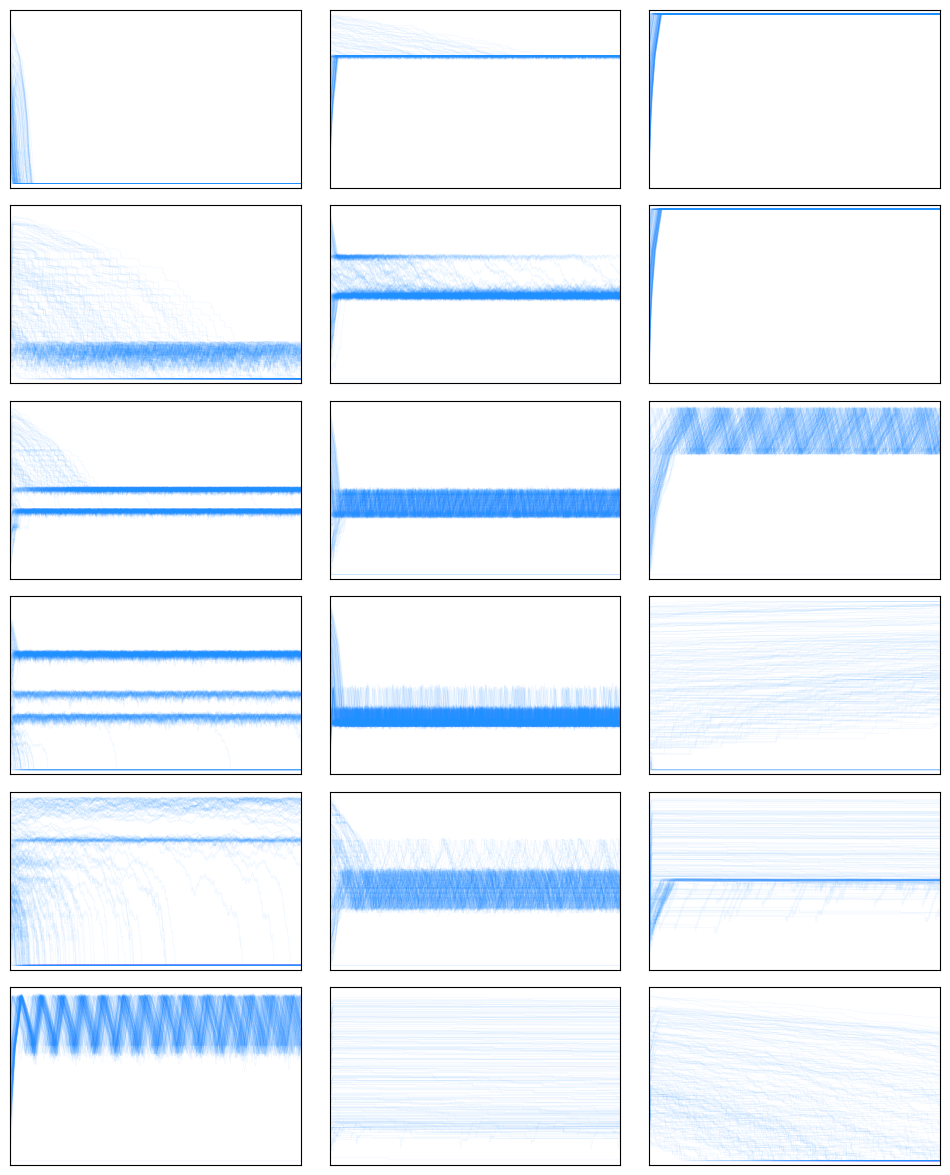

In [29]:
filenames = os.listdir(result_dir)

fig, axs = plt.subplots(6, 3, figsize=(12,15))

num_agents = 200
max_T = 3000
alpha = 0.06

# 1
indices = [3, 106, 431]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[0][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 2
indices = [130, 2, 197]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[1][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 3
indices = [512, 387, 757]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[2][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")
    
# 4
indices = [417, 314, 880]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[3][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 5
indices = [15, 533, 567]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[4][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 6, 7
indices = [253, 896, 54]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[5][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

for i in range(6):
    for j in range(3):
        axs[i][j].set_xlim(0,2500)
        axs[i][j].set_ylim(-4,204)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig("trajectories_zoo.png", bbox_inches="tight")
plt.show()

### Investigate final state space outcome as function of initial state

In [45]:
init_w = []
init_h = []

result_dir = "results_" + result_suffix
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    condition = (wealth[:,-1] <=5) & (health[:,-1] <=5)
    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

  0%|          | 0/1024 [00:00<?, ?it/s]

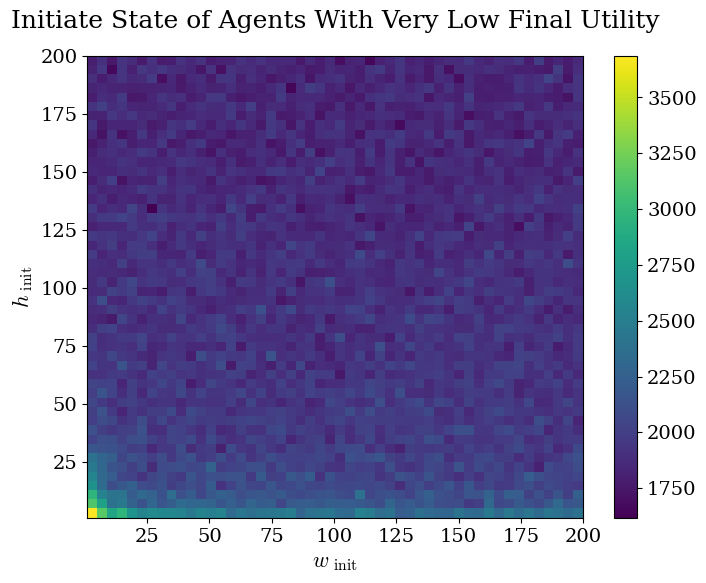

In [46]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)
plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()